In [2]:
import importlib
import src.utils
import src.models

importlib.reload(src.utils)
importlib.reload(src.models)

from src.utils import load_data, load_model, DatasetMetadata
import yaml
import torch
from torch.utils.data import DataLoader
from src.models import LogisticModel
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
def distance(original, new, weights):
    return ((original - new) ** 2 * weights).sum()

orig = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32)
new = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=torch.float32)
weights = torch.tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1], dtype=torch.float32)

print(distance(orig, new, weights))



tensor(2.)


In [4]:
def distance(original, new, weights):
    return ((original - new) ** 2 * weights).sum() #+ reg * A(n) * (1 - torch.cos(2 * torch.pi * new[cols_integers]))

orig = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32)
new = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=torch.float32)
weights = torch.tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 1], dtype=torch.float32)

print(distance(orig, new, weights))



tensor(2.)


In [5]:
filename = 'data/Loan_default.csv'
model_name = "model_small"
model_dict = "models/"+model_name+".pth"

In [6]:
# load the model
test_data: DataLoader
_, _, test_data, _, metadata = load_data(filename, batch_size=1024)

inputs = next(iter(test_data))[0]

# define model
model = load_model(model_name).to(device)

torch.save(model.state_dict(), model_dict)


## Extract equation

In [7]:
import sympy as sp
import torch

def extract_symbolic_equation(model: torch.nn.Module, instance: torch.Tensor):
    """
    Extracts a symbolic equation from a trained PyTorch model.
    Assumes a feedforward structure with linear layers and activations.
    """
    # Define symbolic variables for input features
    x2, x3 = sp.symbols('x2 x3')  # Inputs
    constants = sp.symbols(f'c1:{model.input_dim + 1}')  # Constants for other features
    
    # Build input vector with constants
    x = [instance[i].item() if i not in [1, 2] else (x2 if i == 1 else x3) for i in range(model.input_dim)]
    
    # Convert to a sympy matrix
    X = sp.Matrix(x)

    # Iterate over layers
    for layer in model.layers:
        if isinstance(layer, torch.nn.Linear):
            W = sp.Matrix(layer.weight.detach().numpy())  # Extract weight matrix
            b = sp.Matrix(layer.bias.detach().numpy())    # Extract bias
            X = W * X + b  # Apply linear transformation
        elif isinstance(layer, torch.nn.ReLU):
            X = X.applyfunc(lambda val: sp.Max(0, val))  # ReLU activation
        elif isinstance(layer, torch.nn.Sigmoid):
            X = X.applyfunc(lambda val: 1 / (1 + sp.exp(-val)))  # Sigmoid activation
        # X.subs({sp.symbols(f'c{i+1}'): val for i, val in enumerate(inputs[0]) if i != 1 and i != 2})
        print("Done: ", layer)
        # print(X)


    # Apply softmax at the end
    denominator = sp.Add(*(sp.exp(e) for e in X))
    softmax_expr = sp.Matrix([sp.exp(e) / denominator for e in X])

    return softmax_expr # .simplify()

# Example usage
model_sym = LogisticModel(inputs.shape[1], hidden_sizes=[16, 8])
model_sym.load_state_dict(torch.load(model_dict))  # Load trained weights
symbolic_eq = extract_symbolic_equation(model_sym, inputs[0])
print(symbolic_eq)


Done:  Linear(in_features=24, out_features=16, bias=True)
Done:  Sigmoid()
Done:  Linear(in_features=16, out_features=8, bias=True)
Done:  Sigmoid()
Done:  Linear(in_features=8, out_features=2, bias=True)
Done:  Softmax(dim=1)
Matrix([[1.14736*exp(0.592727/(1.25527*exp(0.60966/(0.18672023781861*exp(0.603065*x2 - 0.420633*x3) + 1) + 0.520607/(0.130793777772998*exp(0.506093*x2 - 0.43031*x3) + 1) + 0.515989/(0.159123828844163*exp(0.410075*x2 - 0.333227*x3) + 1) + 0.538932/(0.149384390603055*exp(0.367078*x2 - 0.39095*x3) + 1) - 0.382252/(4.74907893703268*exp(-0.332786*x2 + 0.335924*x3) + 1) - 0.416536/(7.08653417732447*exp(-0.395104*x2 + 0.519326*x3) + 1) - 0.123144/(5.28290240645382*exp(-0.395989*x2 + 0.341228*x3) + 1) - 0.28782/(7.54697936678862*exp(-0.400508*x2 + 0.289444*x3) + 1) - 0.257044/(7.1508297624139*exp(-0.420954*x2 + 0.472439*x3) + 1) - 0.473963/(4.62519776186675*exp(-0.424769*x2 + 0.478419*x3) + 1) - 0.301906/(4.52632472610194*exp(-0.476373*x2 + 0.434195*x3) + 1) - 0.2646/(7.

In [8]:
# # write the eq to a text file
# with open('small.txt', 'w') as f:
#     f.write(str(symbolic_eq))

## Training

In [9]:
person: torch.Tensor = inputs[4] # 4
metadata.cols_for_mask = [False] * len(metadata.cols_for_mask)
metadata.cols_for_mask[1] = True
metadata.cols_for_mask[2] = True



In [10]:
weights = torch.tensor(metadata.cols_for_mask, dtype=torch.float32).to(device)
print(person)
print(weights)

tensor([-1.6343, -1.3611,  0.3415,  0.1997, -0.7662, -1.3438, -1.0341, -0.7087,
        -0.0875,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float32)
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


In [52]:
def unscale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    unscaled_cols = metadata.scaler.inverse_transform(instance[metadata.cols_for_scaler].detach().cpu().numpy().reshape(1, -1))
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance_clone

In [53]:
def scale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    unscaled_cols = metadata.scaler.transform(instance[metadata.cols_for_scaler].detach().cpu().numpy().reshape(1, -1))
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance_clone

In [124]:
import torch

# Forward pass on the original input
output = model(person.unsqueeze(0))

l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))

# If the model predicts the person is likely to default:
if torch.argmax(output, dim=1).item() == 1:
    print("This person is likely to default")
    
    expected_output = torch.tensor([[1, 0]], dtype=torch.float32).to(device)
    cross_loss = torch.nn.CrossEntropyLoss()
    distance_loss = distance # To be changed by a custom/weighted distance function
    changed_output = False
    
    person_new = person.clone().detach().to(device)
    person_new.requires_grad = True
    
    optimizer = torch.optim.Adam([person_new, l], lr=0.03)
    epochs = 0
    max_epochs = 100000

    track_person = []
    track_l = []
    # LBFGS
    while not changed_output and epochs < max_epochs:
        optimizer.zero_grad()
        
        output_new = model(person_new.unsqueeze(0))
        dist = distance(person, person_new, weights)
        threshold = 0.5
        thres_term = (output_new[0][metadata.good_class] - threshold)
        # Compute the total loss: cross-entropy + distance regularization + TODO integer regularization
        # loss_value = cross_loss(output_new, expected_output) + l * distance(person, person_new, weights) + torch.sum((epochs / 300) ** 2 * (person_new[metadata.int_cols] - torch.round(person_new[metadata.int_cols]))**2)
        # loss_value = (l * cross_loss(output_new, expected_output) + distance(person, person_new, weights))**2 # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
        loss_value = (dist - l * thres_term) ** 2 + thres_term ** 2 # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
        # loss_value = torch.abs(dist - l * thres_term) + torch.abs(thres_term) # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
        
        loss_value.backward()
        
        with torch.no_grad():
            person_new.grad *= weights
        
        optimizer.step()
        
        # Check if the classification has changed
        with torch.no_grad():
            # TODO
            output_new = model(person_new.unsqueeze(0))
            if torch.argmax(output_new, dim=1).item() == 0:
                changed_output = True
        epochs += 1
        if epochs % (max_epochs//60) == 0:
            track_person.append((person_new[1].item(), person_new[2].item()))
            track_l.append(l.item())
            print('epoch:', epochs, ", loss:", loss_value.item(), (dist - l * thres_term).item(), l.item(), ", dist:", dist.item(), ", threshold:", thres_term.item())
        
    
    # After the loop, 'person_new' has been updated
    # person_new = person_new.clone()
    # unscaled_person_new = unscale_instance(person_new, metadata)
    # unscaled_person_new[metadata.int_cols] = torch.round(unscaled_person_new[metadata.int_cols])
    print("Original output:", output)
    print("New output:", output_new)
    print("Original input unscaled:", unscale_instance(person, metadata))
    print("New input unscaled:", unscale_instance(person_new, metadata))
    print("Regularization strength:", l.item())
    print("Epochs:", epochs)


This person is likely to default
epoch: 1666 , loss: 0.0017817719769029786 0.00488304830008951 -10.994230270385742 , dist: 0.465625972343195 , threshold: -0.04190770183194825
epoch: 3332 , loss: 0.0009798735310478546 0.0014141372778422312 -16.31301498413086 , dist: 0.5114637597849935 , threshold: -0.03126642273076574
epoch: 4998 , loss: 0.0006962690644130252 0.000620646198342456 -20.18033790588379 , dist: 0.5329383889692514 , threshold: -0.026378039121718877
epoch: 6664 , loss: 0.001534698835119882 -0.03017183452374972 -23.10433578491211 , dist: 0.5403923814373882 , threshold: -0.02469511442669281
epoch: 8330 , loss: 0.0004758196030586907 0.0007461836293292112 -25.346981048583984 , dist: 0.553288417911221 , threshold: -0.021799133917479285
epoch: 9996 , loss: 0.00042863323479512756 0.0006270790197204779 -26.94692611694336 , dist: 0.5582396807502412 , threshold: -0.020692994789484054
epoch: 11662 , loss: 0.0016762857420300325 0.03639640724344162 -28.23223304748535 , dist: 0.566799114616

In [ ]:
import torch

# Forward pass on the original input
output = model(person.unsqueeze(0))

l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))

# If the model predicts the person is likely to default:
if torch.argmax(output, dim=1).item() == 1:
    print("This person is likely to default")
    
    changed_output = False
    
    person_new = person.clone().detach().to(device)
    person_new.requires_grad = True
    
    optimizer = torch.optim.Adam([person_new, l], lr=1)
    epochs = 0
    max_epochs = 100000

    while not changed_output and epochs < max_epochs:
        optimizer.zero_grad()
        
        output_new = model(person_new.unsqueeze(0))
        dist = distance(person, person_new, weights)
        threshold = 0.5
        thres_term = (output_new[0][metadata.good_class] - threshold)
        loss_value = (dist - l * thres_term) ** 2 + thres_term ** 2 # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
        
        loss_value.backward()
        
        with torch.no_grad():
            person_new.grad *= weights
        
        optimizer.step()
        
        # Check if the classification has changed
        with torch.no_grad():
            # TODO
            output_new = model(person_new.unsqueeze(0))
            if torch.argmax(output_new, dim=1).item() == 0:
                changed_output = True
        epochs += 1
        if epochs % 1 == 0: # (max_epochs//60) == 0:
            print('epoch:', epochs, ", loss:", loss_value.item(), (dist - l * thres_term).item(), l.item(), ", dist:", dist.item(), ", threshold:", thres_term.item())

    
    print("Original output:", output)
    print("New output:", output_new)
    print("Original input unscaled:", unscale_instance(person, metadata))
    print("New input unscaled:", unscale_instance(person_new, metadata))
    print("Regularization strength:", l.item())
    print("Epochs:", epochs)


This person is likely to default
epoch: 1 , loss: 0.08952052456069719 -0.26794323948466564 -0.8999993205070496 , dist: 0.0 , threshold: -0.2977149353109616
epoch: 2 , loss: 3.8813399923725624 1.942113993525126 -1.726619005203247 , dist: 1.999998868611967 , threshold: -0.03352498432624812
epoch: 3 , loss: 0.16762478572305095 -0.291295987023381 -1.6321104764938354 , dist: 0.1337618636909783 , threshold: -0.260434484574528
epoch: 4 , loss: 0.24567565838433084 -0.21529927017541456 -1.1428486108779907 , dist: 0.15606259217597657 , threshold: -0.3249440554213854
epoch: 5 , loss: 0.6145798420892024 0.6189592612067818 -1.3735544681549072 , dist: 1.1030399518623777 , threshold: -0.35242919147273455
epoch: 6 , loss: 2.362529338894702 1.2934492109361715 -1.9271697998046875 , dist: 1.9909823472040018 , threshold: -0.3619469007549428
epoch: 7 , loss: 0.9450037544581873 0.6657850646459451 -2.590834617614746 , dist: 1.5943176971340276 , threshold: -0.3583913176762077
epoch: 8 , loss: 0.12250506117326

KeyboardInterrupt: 

In [116]:
import pandas as pd
a = pd.DataFrame([unscale_instance(person, metadata).detach().cpu().numpy().reshape(-1), unscale_instance(person_new, metadata).detach().cpu().numpy().reshape(-1)], columns=metadata.columns)
a.columns
a

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,18.0,130470.000000,163439.000000,744.0,59.0,4.0,21.99,36.0,0.25,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,18.0,154654.912964,126641.009507,744.0,59.0,4.0,21.99,36.0,0.25,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


### Punto inicial

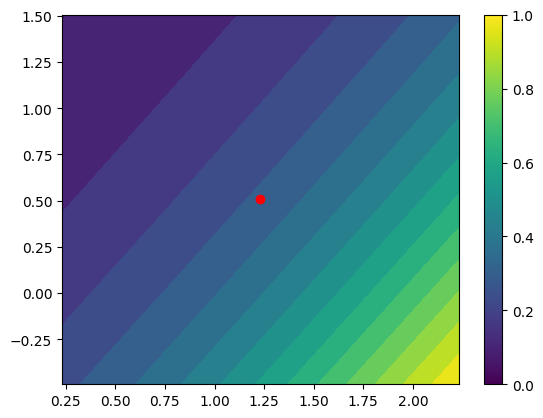

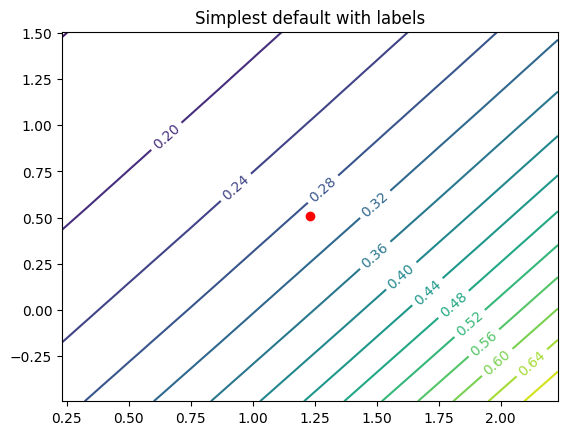

In [117]:
# Draw contour plot
import numpy as np



x = np.linspace(inputs[0][1] - 1, inputs[0][1] + 1, 20)
y = np.linspace(inputs[0][2] - 1, inputs[0][2] + 1, 20)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
dist_Z = np.zeros_like(X)

for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
        temp_inputs = inputs[0].clone()
        temp_inputs[1] = X[i, j]
        temp_inputs[2] = Y[i, j]
        dist_Z[i, j] = distance(inputs[0], temp_inputs, weights)


# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(inputs[0][1], inputs[0][2], c='red')
# plt.colorbar()
# Draw contour lines

plt.show()
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.title('Simplest default with labels')
plt.show()


### Pintando alrededor del punto final

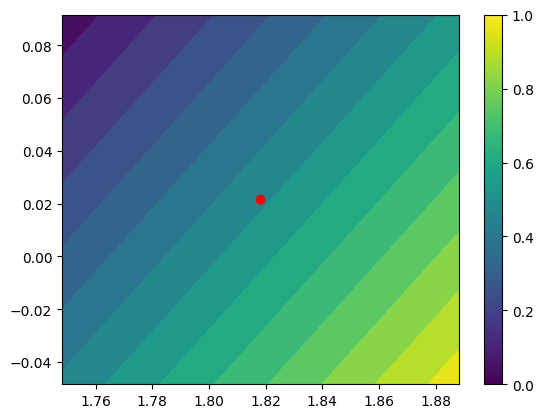

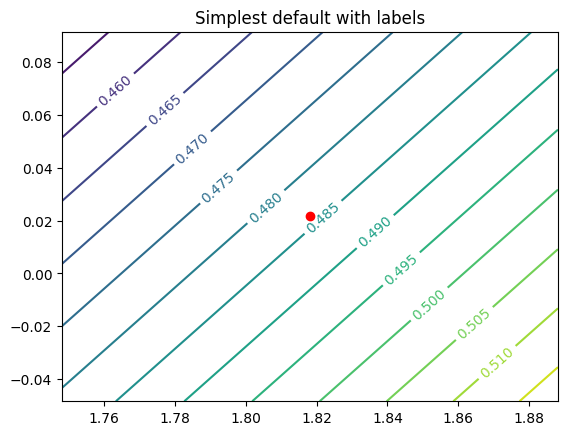

In [ ]:
# Draw contour plot
import numpy as np



x = np.linspace(person_new[1].item() - 0.07, person_new[1].item() + 0.07, 20)
y = np.linspace(person_new[2].item() - 0.07, person_new[2].item() + 0.07, 20)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
dist_Z = np.zeros_like(X)

for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
        temp_inputs = inputs[0].clone()
        temp_inputs[1] = X[i, j]
        temp_inputs[2] = Y[i, j]
        dist_Z[i, j] = distance(inputs[0], temp_inputs, weights)


# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# plt.colorbar()
# Draw contour lines

plt.show()
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
plt.title('Simplest default with labels')
plt.show()


### gradient as an arrow

In [122]:
# plt.figure()
# CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# # Draw the gradient of the point as an arrow
# grad = person_new.grad
# plt.arrow(person_new[1].item(), person_new[2].item(), grad[1].item(), grad[2].item(), head_width=0.005, head_length=0.01, fc='r', ec='r')
# plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# plt.title('Simplest default with labels')
# plt.show()

Text(0.5, 1.0, 'Simplest default with labels')

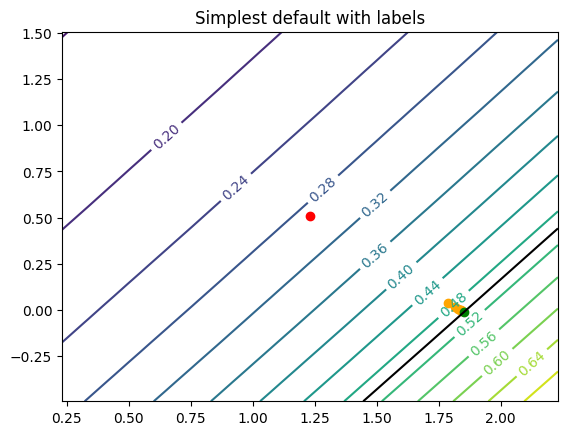

In [118]:
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
# Paint the 0.5 threshold
plt.contour(X, Y, Z, levels=[0.5], colors='black')
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')

Text(0.5, 1.0, 'Simplest default with labels')

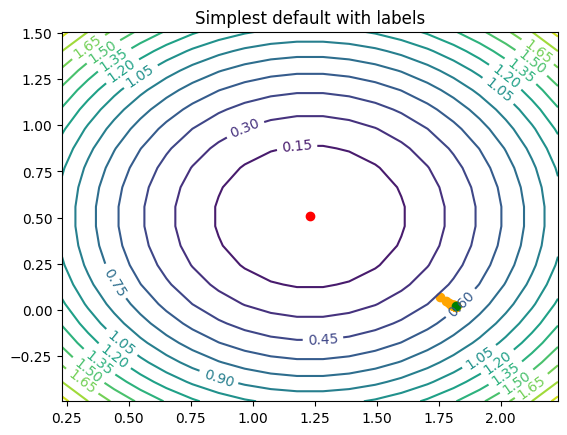

In [87]:
plt.figure()
CS = plt.contour(X, Y, dist_Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')

Text(0.5, 1.0, 'Simplest default with labels')

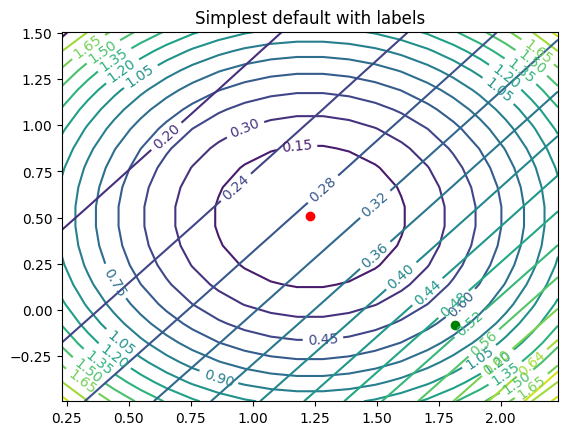

In [121]:
plt.figure()
dist_CS = plt.contour(X, Y, dist_Z, levels=15) # CS is the ContourSet
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(dist_CS, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')

## LBFGS

In [56]:
import torch

# Forward pass on the original input
output = model(person.unsqueeze(0))

l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))

# If the model predicts the person is likely to default:
if torch.argmax(output, dim=1).item() == 1:
    print("This person is likely to default")
    
    expected_output = torch.tensor([[1, 0]], dtype=torch.float32).to(device)
    cross_loss = torch.nn.CrossEntropyLoss()
    distance_loss = torch.nn.MSELoss() # To be changed by a custom/weighted distance function
    changed_output = False
    
    person_new = person.clone().detach().to(device)
    person_new.requires_grad = True
    
    optimizer = torch.optim.LBFGS([person_new, l], lr=0.1, max_iter=1)
    # LBFGS
    count = 0
    while not changed_output:
        def closure():
            global count
            count += 1
            optimizer.zero_grad()
            output_new = model(person_new.unsqueeze(0))
            dist = distance(person, person_new, weights)
            threshold = 0.5
            thres_term = (output_new[0][metadata.good_class] - threshold)
            # Compute the total loss: cross-entropy + distance regularization + TODO integer regularization
            # loss_value = cross_loss(output_new, expected_output) + l * distance(person, person_new, weights) + torch.sum((epochs / 300) ** 2 * (person_new[metadata.int_cols] - torch.round(person_new[metadata.int_cols]))**2)
            # loss_value = (l * cross_loss(output_new, expected_output) + distance(person, person_new, weights))**2 # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
            loss_value = (dist - l * thres_term) ** 2 + epochs * thres_term ** 2 # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
            # loss_value = torch.abs(dist - l * thres_term) + torch.abs(thres_term) # + torch.sum(epochs ** (1/3) * (1 - torch.cos(2 * torch.pi * person_new[metadata.int_cols])))
        
            loss_value.backward()
            with torch.no_grad():
                person_new.grad *= weights
            return loss_value
        
        
        optimizer.step(closure)
        # Check if the classification has changed
        with torch.no_grad():
            output_new = model(person_new.unsqueeze(0))
            print("Iteration:", count)
            print(person_new - person)
            if torch.argmax(output_new, dim=1).item() == 0:
                changed_output = True
    
    # After the loop, 'person_new' has been updated
    print("Original output:", output)
    print("New output:", output_new)
    print("Original input unscaled:", unscale_instance(person, metadata))
    print("New input unscaled:", unscale_instance(person_new, metadata))
    print("Regularization strength:", l.item())


This person is likely to default
Iteration: 1
tensor([ 0.0000,  0.0546, -0.0454,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float32)
Iteration: 2
tensor([  0.0000,  57.7469, -48.1071,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000], dtype=torch.float32)
Original output: tensor([[0.2892, 0.7108]], dtype=torch.float32,
       grad_fn=<DifferentiableGraphBackward>)
New output: tensor([[0.9897, 0.0103]], dtype=torch.float32,
       grad_fn=<DifferentiableGraphBackward>)
Original input unscaled: tensor([1.8000e+01, 1.3047e+05, 1.6344e+05, 7.4400e+02, 5.9000e+01, 4.0000e+00,
        2.1990e+01, 3.6000e+01, 2.5000e-01, 1.0000e+00, 

In [57]:
import pandas as pd
a = pd.DataFrame([unscale_instance(person, metadata).detach().cpu().numpy().reshape(-1), unscale_instance(person_new, metadata).detach().cpu().numpy().reshape(-1)], columns=metadata.columns)
a.columns
a

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,18.0,1.304700e+05,1.634390e+05,744.0,59.0,4.0,21.99,36.0,0.25,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,18.0,2.380460e+06,-3.244494e+06,744.0,59.0,4.0,21.99,36.0,0.25,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
